In [2]:
cd ..

/home/yann/IVISpaces


In [3]:
from Data import get_setup
import os
from datetime import datetime
import timeit

import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import trange
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler
import argparse


In [4]:
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [5]:
## small ##
# predictive model architecture
layerwidth = 50
nblayers = 1
activation = nn.ReLU()



In [6]:
path="Results/Paper/Exp2/Exp2_small2021-01-28-00:59"

In [7]:
MODELS=torch.load(path+"_models.pt",map_location=device)
len(MODELS['yacht'])

10

In [8]:
datasets = ['boston', 'concrete', 'energy','wine','yacht']
# for key in MODELS.keys():
#     datasets.append(key)

methods=[ 'MC dropout','Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
# for key in MODELS['energy'][0][1].keys():
#     methods.append(key)
    
datasets, methods

(['boston', 'concrete', 'energy', 'wine', 'yacht'],
 ['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI'])

In [9]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [10]:
results=[]

for dataset in datasets:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']

        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test)
        metrics = get_metrics(y_pred, torch.tensor(0.), y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model.predict(x_test, 1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
            
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        #Results.append({dataset:split_results})

In [9]:
#torch.save(results,path+'_results.pt')
results=torch.load(path+'_results.pt')

# RMSE

In [20]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis_r')
#df_.style.highlight_min(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
boston,3.444975,3.393448,3.807834,4.263033,3.769535,3.733011
concrete,4.706556,4.126360,5.108250,5.644193,4.719620,4.749167
energy,0.565759,0.410518,0.462742,0.572870,0.436703,0.457069
wine,0.629738,0.640798,0.650321,0.674266,0.736295,0.695587
yacht,0.737363,0.680147,1.152559,1.708311,0.599475,0.911044


In [21]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(2)).astype(str)+""

In [22]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &  MC dropout &    Ensemble &        MFVI &   FuNN-MFVI &     NN-HyVI &   FuNN-HyVI \\
dataset  &             &             &             &             &             &             \\
\midrule
boston   &  3.445±0.34 &  3.393±0.34 &  3.808±0.25 &  4.263±0.48 &   3.77±0.48 &  3.733±0.23 \\
concrete &  4.707±0.18 &  4.126±0.23 &  5.108±0.15 &  5.644±0.24 &   4.72±0.16 &  4.749±0.27 \\
energy   &  0.566±0.02 &  0.411±0.02 &  0.463±0.02 &  0.573±0.03 &  0.437±0.04 &  0.457±0.04 \\
wine     &   0.63±0.01 &  0.641±0.02 &   0.65±0.01 &  0.674±0.01 &  0.736±0.01 &  0.696±0.02 \\
yacht    &  0.737±0.07 &   0.68±0.07 &  1.153±0.07 &  1.708±0.17 &  0.599±0.07 &  0.911±0.09 \\
\bottomrule
\end{tabular}



# LPP

In [17]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis')
#df_.style.highlight_max(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
boston,-6.788178,-4.242977,-2.829286,-7.610205,-4.499601,-13.085541
concrete,-5.376995,-6.191169,-3.084943,-3.620637,-3.264159,-3.597451
energy,-1.001988,-1.785005,-0.665173,-1.308607,-0.567198,-0.870031
wine,-11.671109,-2.352902,-0.991279,-1.196186,-1.359147,-1.454882
yacht,-0.593607,-0.797440,-1.654285,-4.658845,-0.974485,-4.203983


In [18]:
for i in df_.columns:
    df_[i] = df_[i].round(2).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [19]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &   MC dropout &     Ensemble &         MFVI &    FuNN-MFVI &      NN-HyVI &     FuNN-HyVI \\
dataset  &              &              &              &              &              &               \\
\midrule
boston   &  -6.79±0.681 &  -4.24±0.304 &  -2.83±0.101 &   -7.61±2.31 &   -4.5±0.935 &  -13.09±1.207 \\
concrete &   -5.38±0.31 &  -6.19±1.566 &  -3.08±0.041 &  -3.62±0.143 &  -3.26±0.107 &    -3.6±0.217 \\
energy   &   -1.0±0.047 &  -1.79±0.281 &  -0.67±0.048 &  -1.31±0.128 &  -0.57±0.079 &   -0.87±0.209 \\
wine     &  -11.67±1.23 &  -2.35±0.193 &  -0.99±0.024 &   -1.2±0.041 &  -1.36±0.051 &   -1.45±0.066 \\
yacht    &  -0.59±0.034 &   -0.8±0.394 &  -1.65±0.124 &  -4.66±0.529 &  -0.97±0.264 &    -4.2±1.201 \\
\bottomrule
\end{tabular}



# displaying logs

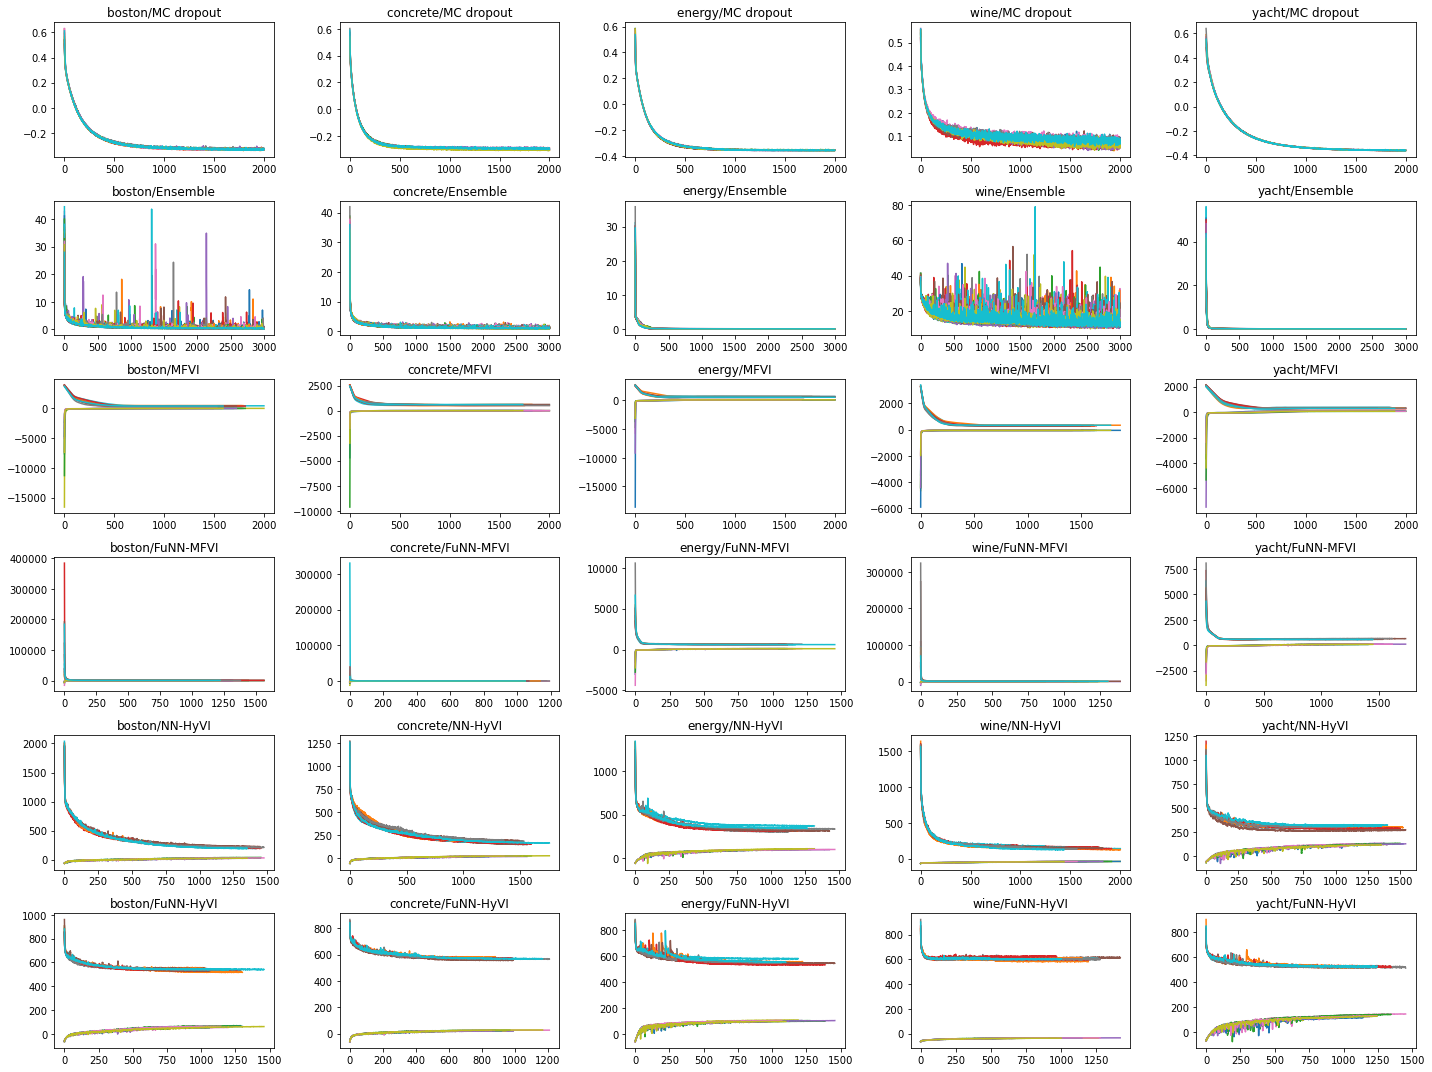

In [23]:
from pylab import *
fig, ax=plt.subplots(len(methods), len(datasets), figsize=(20,15))
ax=ax.flatten()
i=0
for method in methods:
    for dataset in datasets:
        for split in MODELS[dataset]: 
            logs=split[1][method][1]
            for key in logs.keys():
                if key=='KL' or key=='loss' or key=='LL' or isinstance(key, int): 
                    ax[i].plot(range(len(logs[key])), logs[key])
                #ax[i].legend()
                ax[i].set_title(dataset+'/'+method)
        i+=1

fig.tight_layout()

# OOD detection

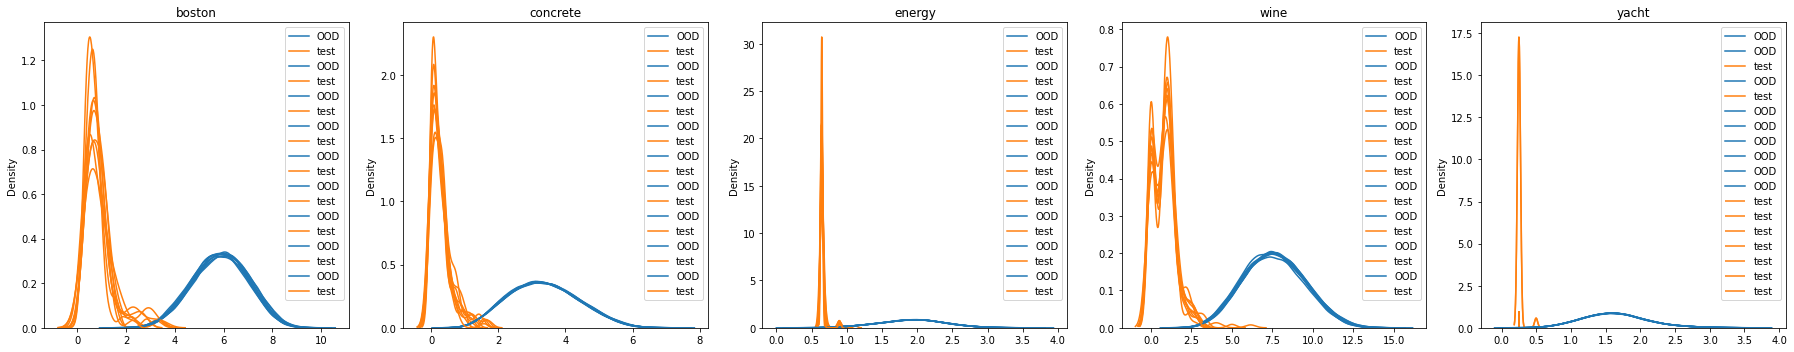

In [33]:
import seaborn as sns
from pylab import *
from torch.distributions import MultivariateNormal
from matplotlib.colors import ListedColormap

cmap=ListedColormap(sns.color_palette("tab10").as_hex())

def nn_dist(X):
    #X_in=torch.cat([X[0],X[1]])
    X_train=X[0]
    X_test=X[1]
    X_ood=X[2]
    dist_ood=torch.cdist(X_train,X_ood)
    dist_test=torch.cdist(X_train,X_test)
    #print(X_in.shape, X_ood.shape, dist.shape)
    return dist_test.min(dim=0)[0], dist_ood.min(dim=0)[0]

fig, ax=plt.subplots(1,5, figsize=(25,5))
ax=ax.flatten()
i=0
for dataset in datasets:
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=50000) #MultivariateNormal(x_train.mean(0), covariance_matrix=.5*torch.diag(x_train.std(0))) #
        x_OOD=OOD_sampler()#OOD_sampler.sample((50000,))
        
        X = [x_train, x_test, x_OOD]
        if split_nb<10:
            test, ood= nn_dist(X)
            sns.kdeplot(ood.cpu(), ax=ax[i], color=cmap(0),label='OOD')
            ax[i].set_title(dataset)
            if test.std() < 0.001:
                ax[i].vlines(x=test.mean(), ymin=0, ymax=1, color=cmap(1), label='test')
            else:
                sns.kdeplot(test.cpu(), ax=ax[i], color=cmap(1), label='test')
            ax[i].legend()
    i+=1
fig.tight_layout()

In [38]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

VARs={dataset:{method: [] for method in methods} for dataset in datasets}
#Hs=torch.load(path+'_epist_entropy_50k.pt')
#MODELS.to(device)
def VAR(model, X):
#    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]
    return [torch.cat([model(x_, 1000).detach().std(0).squeeze() for x_ in x.split(500,dim=0)],dim=0) for x in X]


n_ood=10000
for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_ood) #MultivariateNormal(x_train.mean(0), covariance_matrix=.5*torch.diag(x_train.std(0))) #
        x_OOD=OOD_sampler() #OOD_sampler.sample((n_ood,))#
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
        #Y=[model.predict(x, 1000) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        torch.save(VARs,path+'_epist_VAR_10k.pt')

boston
0
1
2
3
4
5
6
7
8
9
concrete
0
1
2
3
4
5
6
7
8
9
energy
0
1
2
3
4
5
6
7
8
9
wine
0
1
2
3
4
5
6
7
8
9
yacht
0
1
2
3
4
5
6
7
8
9


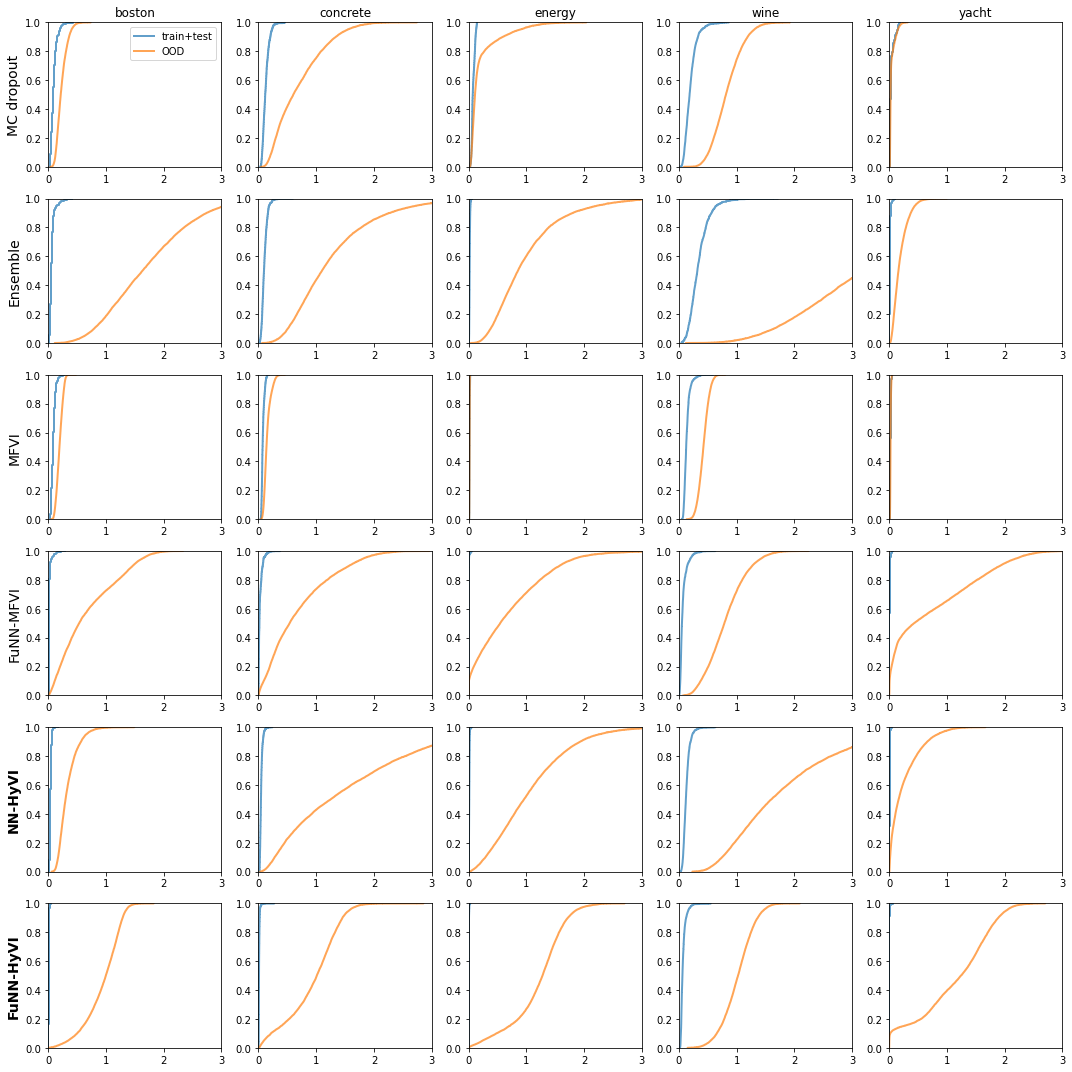

In [36]:
from pylab import *
import seaborn as sns
import pandas as pd

VARs=torch.load(path+'_epist_VAR_10k.pt')

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=VARs
n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(15,15),squeeze=False)

data_type=['train+test', 'OOD']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in datasets:
    m=0
    ax[m,d].set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        for i in range(len(H)):
            #sns.histplot(H[i].cpu(), stat='density', element='step', alpha = .7, kde=True, color=cmap(i), label=data_type[i],ax=ax[m,d])#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m,d],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if (m,d) == (0,0): 
            ax[m,d].legend()#.remove()
        ax[m,d].set_xlim(left=0, right=3)
        ax[m,d].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarECDF_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

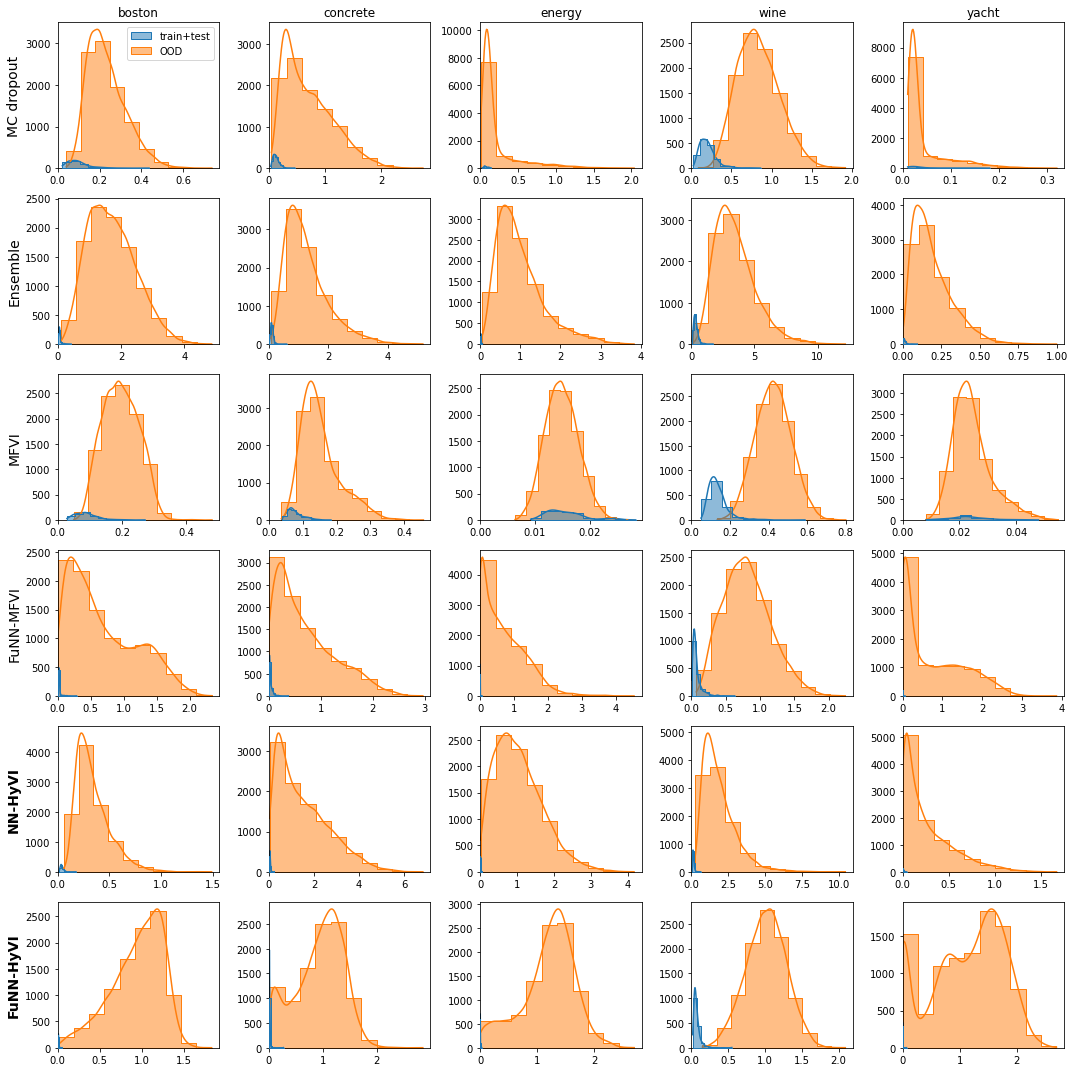

In [39]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=VARs
n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(15,15),squeeze=False)

data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in datasets:
    m=0
    max_var=[]
    ax[m,d].set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]

        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            sns.histplot(H[i].cpu(), stat='count', bins=10, element='step', alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m,d], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            #sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m,d],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if (m,d) == (0,0): 
            ax[m,d].legend()#.remove()
        ax[m,d].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1
    for m in range(n_methods):
        ax[m,d].set_xlim(left=0.)#, right=3)#np.max(max_var))

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarDist_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

MC dropout
Ensemble
MFVI
FuNN-MFVI
NN-HyVI
FuNN-HyVI


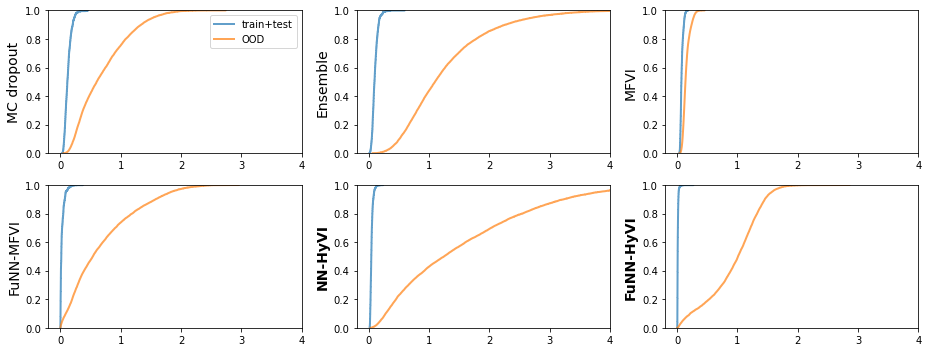

In [42]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=VARs
n_methods=len(methods)
fig,ax=plt.subplots(2,3,figsize=(13,5),squeeze=True)
ax=ax.flatten()
data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in ['concrete']:
    m=0
    max_var=[]
    #ax.set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        print(method)
        
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            #sns.histplot(H[i].cpu(), stat='density', bins=10, element='step', alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if m==0: 
            ax[m].legend()#.remove()
        ax[m].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m].set_ylabel(method)
        m+=1
    for m in range(n_methods):
        ax[m].set_xlim(left=-.2, right=4)
        #ax[m].set_ylim(bottom=0., top=1.1)


    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
#fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarECDF_Exp2-{}.pdf".format(dataset), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

In [46]:
VARs=torch.load(path+'_epist_VAR_10k.pt')
from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=VARs
roc_data={dataset:{} for dataset in datasets}
AUC={}#{dataset:{} for dataset in datsets}

fpr=torch.arange(n_ood).true_divide(n_ood)

for dataset in datasets:     
    for method in methods:
        AUCs=[]

        TPRs=[]
        for h in Hs[dataset][method]:
            H_in=h[1].cpu()#torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            TPRs.append((H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in)))

            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))
        roc_data[dataset].update({method: {'AUC':np.mean(AUCs),'tpr_mean': torch.stack(TPRs).mean(0), 'tpr_min':torch.stack(TPRs).min(0)[0], 'tpr_max':torch.stack(TPRs).max(0)[0]}})

        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))

boston/MC dropout: 0.9380023715415021
boston/Ensemble: 0.9993997826086956
boston/MFVI: 0.9614122233201583
boston/FuNN-MFVI: 0.9918371343873517
boston/NN-HyVI: 0.9983807509881423
boston/FuNN-HyVI: 0.9996314031620553
concrete/MC dropout: 0.9513538689320388
concrete/Ensemble: 0.9992105533980583
concrete/MFVI: 0.9331735145631068
concrete/FuNN-MFVI: 0.9719009320388349
concrete/NN-HyVI: 0.9975674466019416
concrete/FuNN-HyVI: 0.9972033300970873
energy/MC dropout: 0.7725259505208334
energy/Ensemble: 0.9999936328125001
energy/MFVI: 0.4235819791666667
energy/FuNN-MFVI: 0.9452208072916666
energy/NN-HyVI: 0.9998747916666666
energy/FuNN-HyVI: 0.9996485677083335
wine/MC dropout: 0.9922516666666666
wine/Ensemble: 0.9984975859912446
wine/MFVI: 0.9943598843026891
wine/FuNN-MFVI: 0.9965381113195747
wine/NN-HyVI: 0.9991289868667919
wine/FuNN-HyVI: 0.9997725078173859
yacht/MC dropout: 0.5265818344155844
yacht/Ensemble: 0.9947554870129871
yacht/MFVI: 0.5313240746753247
yacht/FuNN-MFVI: 0.9266738311688313
y

<ipython-input-49-1ca8e3b7e284>:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


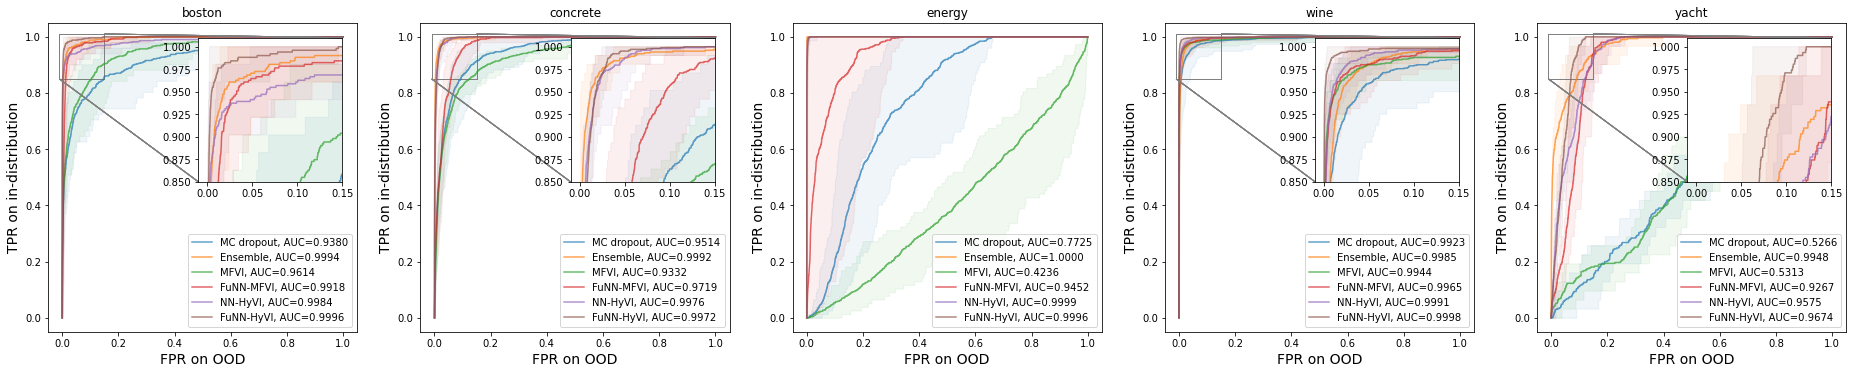

In [49]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.colors import ListedColormap

from pylab import *
import seaborn as sns
l=len(datasets)
fig, ax= plt.subplots(1,l,figsize=(5*l+1,5))
d=0
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
R=[0.15 for _ in range(6)]
B=[0.85 for _ in range(6)]

methods=['MC dropout','Ensemble','MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']

def add_zero(x):
    return torch.cat([torch.zeros(1,1),x.view(-1,1)]).squeeze()
fpr=add_zero(torch.arange(n_ood).true_divide(n_ood))
colors=[]
for dataset in datasets:
    c=0
    if not dataset == 'energy': 
        zoom_ax = inset_axes(ax[d], width=2, height=2,  loc='upper right', borderpad=1.5)      
    for method in methods:
        AUC=roc_data[dataset][method]['AUC']
        tpr_mean=add_zero(roc_data[dataset][method]['tpr_mean'])
        tpr_min=add_zero(roc_data[dataset][method]['tpr_min'])
        tpr_max=add_zero(roc_data[dataset][method]['tpr_max'])
        ax[d].plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        ax[d].fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))
        if not dataset == 'energy': 
            zoom_ax.plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
            zoom_ax.fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))  
            mark_inset(ax[d], zoom_ax, loc1=1, loc2=3, fc="none", ec="0.5")

        c+=1
    zoom_ax.set_xlim(left=-0.01, right=R[d])
    zoom_ax.set_ylim(bottom=B[d], top=1.01)
    zoom_ax.legend().remove()
    zoom_ax.set_xlabel('')
    zoom_ax.set_ylabel('')
    zoom_ax.set_aspect('equal')
    ax[d].legend()
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_xlim(left=-0.05, right=1.05)
    ax[d].set_ylim(bottom=-.05, top=1.05)
    ax[d].set_aspect('equal')

    d+=1


fig.tight_layout()
plt.savefig(path+"ROC_curves_VAR_MinMax.pdf", dpi=600)


<ipython-input-50-5d60545672b8>:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


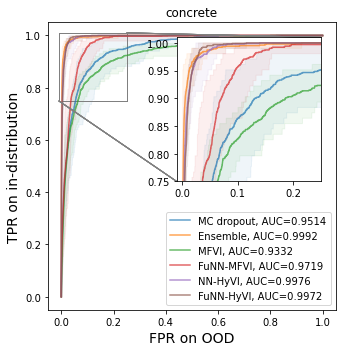

In [50]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.colors import ListedColormap

from pylab import *
import seaborn as sns
l=1
fig, ax= plt.subplots(1,l,figsize=(5*l,5))
dataset='concrete'
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
R=[0.25]
B=[ 0.75]
ax=[ax]
def add_zero(x):
    return torch.cat([torch.zeros(1,1),x.view(-1,1)]).squeeze()
n_ood=10000

fpr=add_zero(torch.arange(n_ood).true_divide(n_ood))
d=0
for dataset in [dataset]:
    c=0

    zoom_ax = inset_axes(ax[d], width=2, height=2,  loc='upper right',borderpad=1.5)      
    for method in methods:
        AUC=roc_data[dataset][method]['AUC']
        tpr_mean=add_zero(roc_data[dataset][method]['tpr_mean'])
        tpr_min=add_zero(roc_data[dataset][method]['tpr_min'])
        tpr_max=add_zero(roc_data[dataset][method]['tpr_max'])
        ax[d].plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        ax[d].fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))

        zoom_ax.plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        zoom_ax.fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))  
        mark_inset(ax[d], zoom_ax, loc1=1, loc2=3, fc="none", ec="0.5")

        c+=1
    zoom_ax.set_xlim(left=-0.01, right=R[d])
    zoom_ax.set_ylim(bottom=B[d], top=1.01)
    zoom_ax.legend().remove()
    zoom_ax.set_xlabel('')
    zoom_ax.set_ylabel('')
    zoom_ax.set_aspect('equal')
    ax[d].legend()
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_xlim(left=-0.05, right=1.05)
    ax[d].set_ylim(bottom=-.05, top=1.05)
    ax[d].set_aspect('equal')

    d+=1


fig.tight_layout()
plt.savefig(path+"_ROC_curves_{}.pdf".format(dataset), dpi=600)


In [32]:
AUC_VAR=torch.load(path+'_AUC_VAR50k.pt')
AUC=torch.load(path+'_AUC_50k.pt')
AUC_compare={dataset:{} for dataset in datasets}
for key in AUC_VAR.keys():
    AUC_compare[key[0]].update({(key[1],"AUC VAR"):AUC_VAR[key],(key[1],'AUC Entropy'):AUC[key]})


index=pd.MultiIndex.from_product([methods,["AUC VAR","AUC Entropy"]])#, names=['method', 'metric']


pd.DataFrame(AUC_compare).transpose().style.background_gradient(axis=1,cmap='viridis')#.highlight_max(axis=1)#, index=index)#.transpose()#, columns=index, index=datasets)

# Parametric vs Predictor Entropy

In [51]:
from Metrics import entropy_nne
def FunH(model, sampler, n=100, n_MC=200):
    Hs=[entropy_nne(model(sampler()).squeeze(2), k=1, k_MC=n_MC).item() for _ in range(n)]
    return np.mean(Hs)



In [54]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

Hs={dataset:{} for dataset in datasets}

def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)

nb_predictors=1000    
n_MC=200
    
for dataset in datasets:
    print(dataset)
    split_nb=0
    Hs[dataset].update({(method,'parameter'):[] for method in methods})
    Hs[dataset].update({(method,'predictor'):[] for method in methods})

    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_MC)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.get_parameters, k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(model, OOD_sampler, n=100, n_MC=200))

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
      #  Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
#        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model.predict(x,nb_predictors), OOD_sampler, n=100, n_MC=200))
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        

boston
0
1
2
3
4
5
6
7
8
9
concrete
0
1
2
3
4
5
6
7
8
9
energy
0
1
2
3
4
5
6
7
8
9
wine
0
1
2
3
4
5
6
7
8
9
yacht
0
1
2
3
4
5
6
7
8
9


In [56]:
torch.save(Hs,path+'_ParamVsPredictor_entropy.pt')
#Hs=torch.load(path+'_ParamVsPredictor_entropy.pt')


In [57]:
import pandas as pd

H_mean={} 
H_std={}
for dataset, value in Hs.items():
    #print(dataset)
    H_mean.update({dataset:{}})
    H_std.update({dataset:{}})
    for key2, results in value.items():
        #print(key2)
        H_mean[dataset].update({key2:np.mean(results)})
        H_std[dataset].update({key2:np.std(results)})

/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [62]:
methods=['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
index=pd.MultiIndex.from_product([methods,["parameter"]])
df=pd.DataFrame(H_mean, index=index).transpose()
df_=pd.DataFrame(H_std, index=index).transpose()
df.style.background_gradient(axis=1,cmap='viridis')

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,parameter,parameter,parameter,parameter,parameter,parameter
boston,nan,494.695557,518.342419,-1744.242041,1259.320288,-1317.423718
concrete,nan,530.439612,221.419165,-1230.700024,860.976147,-974.825177
energy,nan,202.969641,265.138501,-1036.386505,522.837268,-1530.528186
wine,nan,933.094531,445.160657,-1231.571863,1374.656055,-994.449738
yacht,nan,169.060718,236.262622,-771.534094,335.117975,-936.474078


In [63]:
for i in df.columns:
    df[i] = df[i].round().astype(str)+ "±" + (df_[i].round()).astype(str)+""

print(df.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & MC dropout &    Ensemble &        MFVI &      FuNN-MFVI &      NN-HyVI &     FuNN-HyVI \\
{} &  parameter &   parameter &   parameter &      parameter &    parameter &     parameter \\
\midrule
boston   &    nan±nan &  495.0±16.0 &  518.0±11.0 &  -1744.0±129.0 &  1259.0±25.0 &  -1317.0±62.0 \\
concrete &    nan±nan &  530.0±12.0 &  221.0±20.0 &  -1231.0±121.0 &   861.0±26.0 &   -975.0±39.0 \\
energy   &    nan±nan &  203.0±10.0 &  265.0±18.0 &  -1036.0±109.0 &   523.0±28.0 &  -1531.0±47.0 \\
wine     &    nan±nan &  933.0±19.0 &  445.0±11.0 &  -1232.0±106.0 &  1375.0±49.0 &   -994.0±69.0 \\
yacht    &    nan±nan &   169.0±9.0 &   236.0±8.0 &   -772.0±104.0 &   335.0±26.0 &   -936.0±40.0 \\
\bottomrule
\end{tabular}



In [64]:
index=pd.MultiIndex.from_product([methods,["predictor"]])
df=pd.DataFrame(H_mean, index=index).transpose()
df_=pd.DataFrame(H_std, index=index).transpose()
df.style.background_gradient(axis=1,cmap='viridis')

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,predictor,predictor,predictor,predictor,predictor,predictor
boston,-492.421537,-103.499736,-628.305671,-412.022165,-517.905993,-241.263737
concrete,-404.650365,-154.265631,-694.182629,-395.192615,-406.979392,-258.643981
energy,-477.911203,-297.617977,-1145.607515,-367.437082,-381.575752,-304.581709
wine,-234.297302,49.696883,-486.714441,-331.822106,-241.412274,-250.232586
yacht,-812.031318,-531.445485,-1067.799141,-346.365311,-654.061813,-280.678440


In [65]:
for i in df.columns:
    df[i] = df[i].round().astype(str)+ "±" + (df_[i].round()).astype(str)+""

print(df.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &   MC dropout &     Ensemble &          MFVI &    FuNN-MFVI &      NN-HyVI &    FuNN-HyVI \\
{} &    predictor &    predictor &     predictor &    predictor &    predictor &    predictor \\
\midrule
boston   &  -492.0±17.0 &  -103.0±18.0 &   -628.0±20.0 &  -412.0±31.0 &  -518.0±20.0 &  -241.0±10.0 \\
concrete &  -405.0±57.0 &  -154.0±10.0 &   -694.0±16.0 &  -395.0±30.0 &  -407.0±34.0 &   -259.0±4.0 \\
energy   &  -478.0±40.0 &  -298.0±33.0 &  -1146.0±12.0 &  -367.0±42.0 &  -382.0±50.0 &  -305.0±14.0 \\
wine     &  -234.0±19.0 &    50.0±13.0 &   -487.0±27.0 &  -332.0±14.0 &  -241.0±36.0 &   -250.0±6.0 \\
yacht    &  -812.0±12.0 &  -531.0±25.0 &  -1068.0±32.0 &  -346.0±38.0 &  -654.0±36.0 &   -281.0±4.0 \\
\bottomrule
\end{tabular}

